## Deep Learning model for Multi class Satellite image classification and Prediction

### Import neccsary libraries

In [1]:

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img



In [2]:


import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [3]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=30
CHANNELS=3

### Load dataset

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\mahas\Downloads\Semi\Dataset\data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5631 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['cloudy', 'desert', 'green_area', 'water']

In [6]:
len(dataset)

91

### Preprocessing

In [7]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[43.       60.       67.      ]
  [43.       60.       67.      ]
  [43.       60.125    66.75    ]
  ...
  [58.       77.25     74.875   ]
  [58.       77.       75.      ]
  [58.       77.       75.      ]]

 [[43.       60.       67.      ]
  [43.       60.       67.      ]
  [43.       60.125    66.75    ]
  ...
  [58.       77.25     74.875   ]
  [58.       77.       75.      ]
  [58.       77.       75.      ]]

 [[43.       60.       67.      ]
  [43.       60.       67.      ]
  [43.015625 60.140625 66.765625]
  ...
  [57.890625 77.140625 74.546875]
  [57.875    76.875    74.625   ]
  [57.875    76.875    74.625   ]]

 ...

 [[51.125    93.125    73.125   ]
  [51.125    93.125    73.125   ]
  [51.171875 93.125    73.140625]
  ...
  [41.828125 71.046875 66.828125]
  [41.625    70.875    66.625   ]
  [41.625    70.875    66.625   ]]

 [[51.       93.       73.      ]
  [51.       93.       73.      ]
  [51.       93.       73.      ]
  ...
  [42.125

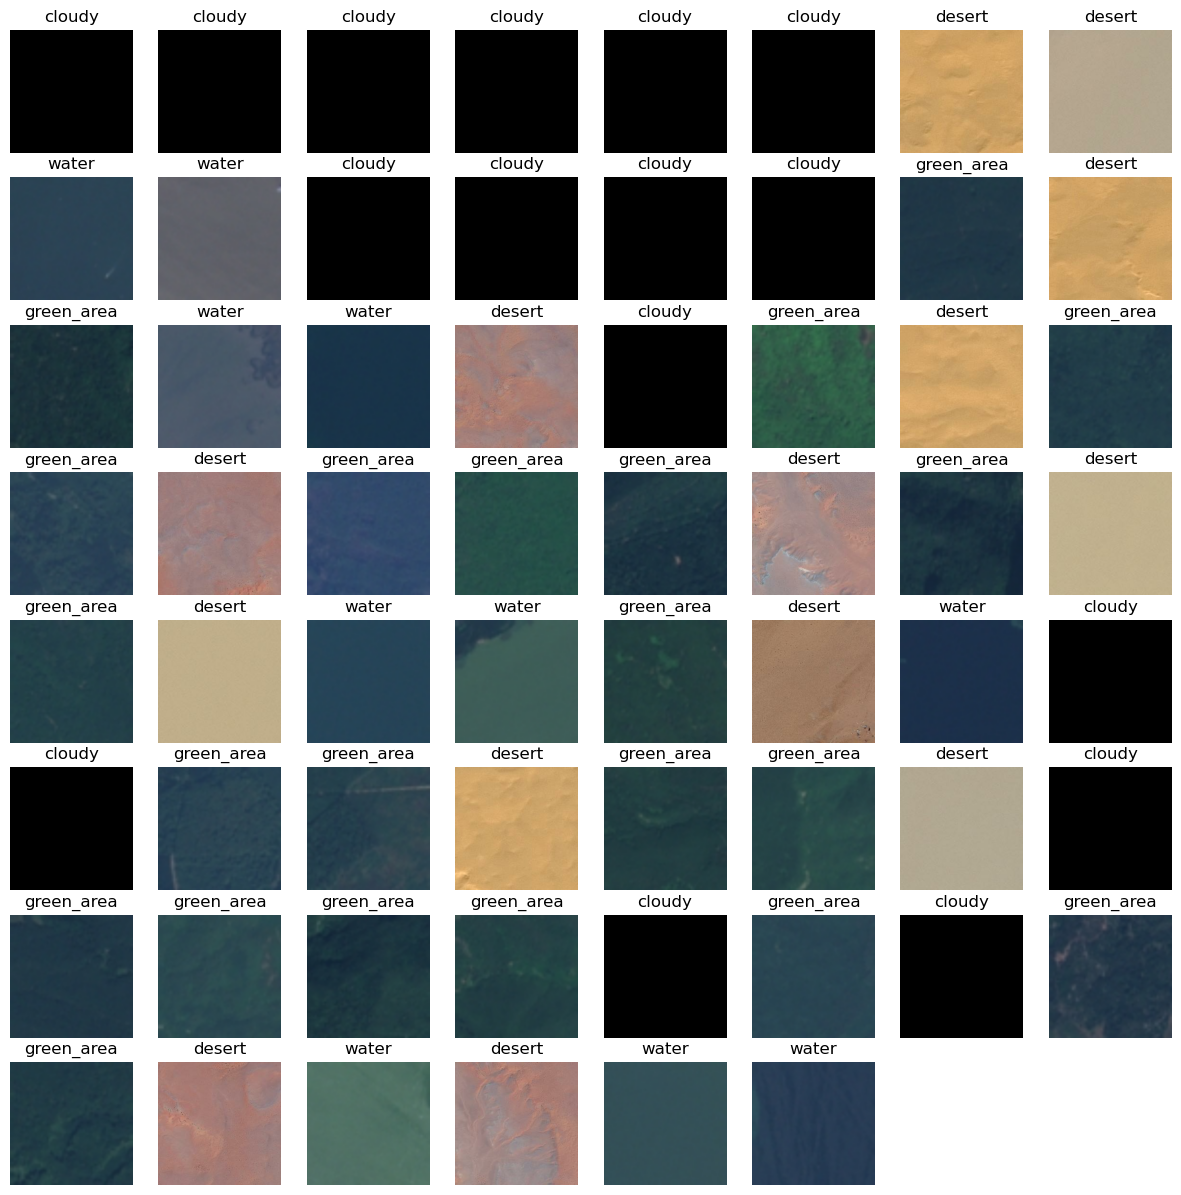

In [8]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Creation

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (62, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (62, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

### Training model

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
72/72 [==============================] - 171s 2s/step - loss: 0.8116 - accuracy: 0.6409 - val_loss: 0.3315 - val_accuracy: 0.7993
Epoch 2/30
72/72 [==============================] - 175s 2s/step - loss: 0.3153 - accuracy: 0.8421 - val_loss: 0.3559 - val_accuracy: 0.7401
Epoch 3/30
72/72 [==============================] - 174s 2s/step - loss: 0.3747 - accuracy: 0.7483 - val_loss: 0.3325 - val_accuracy: 0.8728
Epoch 4/30
72/72 [==============================] - 170s 2s/step - loss: 0.3155 - accuracy: 0.8408 - val_loss: 0.2387 - val_accuracy: 0.8961
Epoch 5/30
72/72 [==============================] - 168s 2s/step - loss: 0.2468 - accuracy: 0.8900 - val_loss: 0.2488 - val_accuracy: 0.8853
Epoch 6/30
72/72 [==============================] - 171s 2s/step - loss: 0.2627 - accuracy: 0.8808 - val_loss: 0.2783 - val_accuracy: 0.8638
Epoch 7/30
72/72 [==============================] - 170s 2s/step - loss: 0.2467 - accuracy: 0.8832 - val_loss: 0.2682 - val_accuracy: 0.8602
Epoch 8/30
72

### Model Evaluation


In [ ]:
model.evaluate(test_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

In [ ]:
image_path = r"C:\Users\mahas\Downloads\Semi\Dataset\data\cloudy\train_601.jpg"

image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [ ]:
pred = model.predict(scaled_img)

In [ ]:
output = class_names[np.argmax(pred)]

In [ ]:
output

In [ ]:
model.save("satellite_image2.h5")